In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F

from utils2 import Logger

### Import dataset

In [2]:
batch_size_train = 150

data_dir = 'data/'

image_loader = torch.utils.data.DataLoader(
  datasets.MNIST(data_dir, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((.5), (.5))
                             ])),
  batch_size=batch_size_train, shuffle=True)

# Num batches
num_batches = len(image_loader)

### Defining networks

In [3]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),
        )
        self.hidden1 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(320, 50),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(50, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = x.view(-1, 320)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    

In [65]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        
        self.linear1 = nn.Sequential(
            nn.Linear(n_features, 540),
            nn.LeakyReLU(0.2)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(200, 540),
            nn.LeakyReLU(0.2)
        )
        self.conv1 = nn.Sequential(            
            nn.ConvTranspose2d(15, 10, kernel_size=10),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(10, 1, kernel_size=14),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.linear1(x)
        #x = self.linear2(x)
        x = x.view(-1, 15, 6, 6)
        x = self.conv1(x)
        x = self.conv2(x)
        return x
    

In [54]:
tensor_test = torch.rand(100)

linear1 = nn.Linear(100, 200)
linear2 = nn.Linear(200, 540)

conv1 = nn.ConvTranspose2d(15, 10, kernel_size=10)
conv2 = nn.ConvTranspose2d(10, 1, kernel_size=14)

out = linear1(tensor_test)
out = linear2(out)
out = out.view(-1, 15, 6, 6)
#out = torch.rand(1 , 20, 10, 10)
out = conv1(out)
out = conv2(out)
out.shape

torch.Size([1, 1, 28, 28])

### Helper functions

In [55]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

### Training

In [56]:
#check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [68]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

generator.to(device)
discriminator.to(device)

#Define loss function and both optimizer functions
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.002)
#g_optimizer = optim.Adam(generator.parameters(), lr=0.002)
loss = nn.BCELoss()

In [58]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N).to(device) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N).to(device))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [59]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    #Send data to device
    fake_data = fake_data.to(device)
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N).to(device))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [60]:
num_test_samples = 16
test_noise = noise(num_test_samples).to(device)

In [61]:
#Test here
#fake_data = generator(noise(3).to(device)).detach()

#n_batch, (real_batch,_) = next(enumerate(image_loader))

#real_batch.shape

#plt.imshow(real_batch[50][0].cpu().detach().numpy(), cmap='gray', interpolation='none')

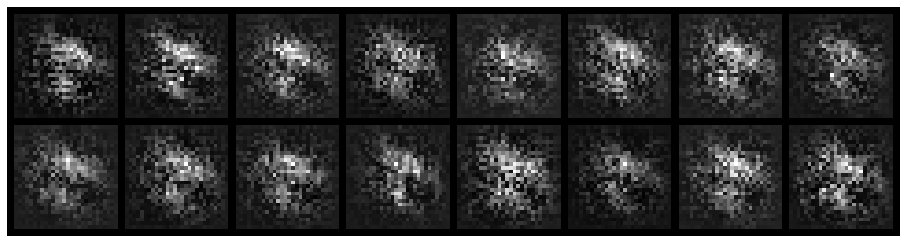

Epoch: [0/100], Batch Num: [0/400]
Discriminator Loss: 1.3614, Generator Loss: 0.7263
D(x): 0.4964, D(G(z)): 0.4834


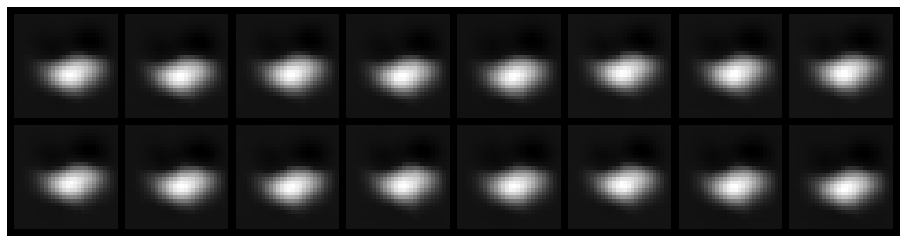

Epoch: [0/100], Batch Num: [100/400]
Discriminator Loss: 0.6560, Generator Loss: 1.8590
D(x): 0.6443, D(G(z)): 0.1900


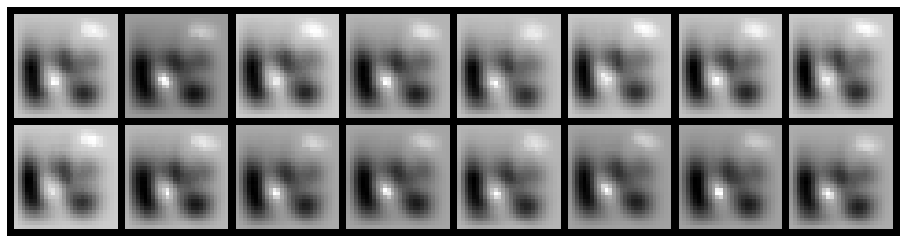

Epoch: [0/100], Batch Num: [200/400]
Discriminator Loss: 1.1401, Generator Loss: 0.7975
D(x): 0.6054, D(G(z)): 0.4640


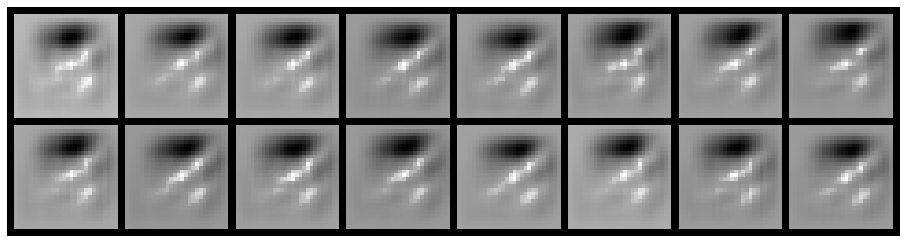

Epoch: [0/100], Batch Num: [300/400]
Discriminator Loss: 1.2438, Generator Loss: 1.2749
D(x): 0.4379, D(G(z)): 0.3193


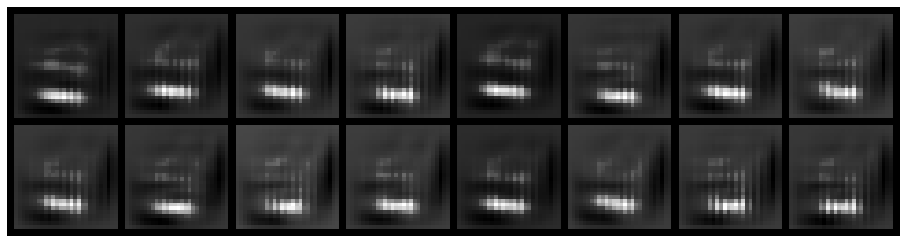

Epoch: [1/100], Batch Num: [0/400]
Discriminator Loss: 2.1111, Generator Loss: 0.4974
D(x): 0.4244, D(G(z)): 0.6769


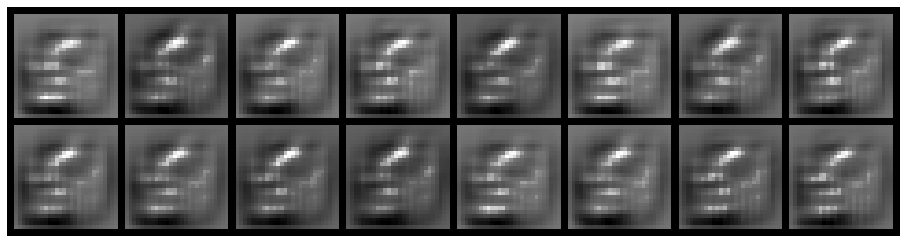

Epoch: [1/100], Batch Num: [100/400]
Discriminator Loss: 1.3481, Generator Loss: 0.6952
D(x): 0.5248, D(G(z)): 0.5004


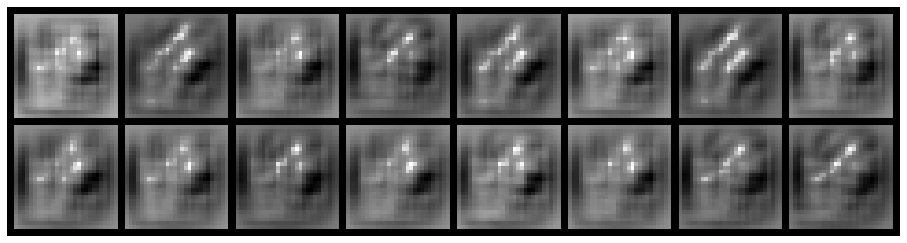

Epoch: [1/100], Batch Num: [200/400]
Discriminator Loss: 1.3130, Generator Loss: 0.8796
D(x): 0.4623, D(G(z)): 0.4129


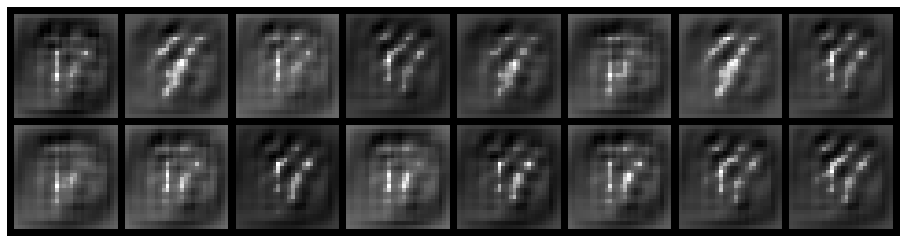

Epoch: [1/100], Batch Num: [300/400]
Discriminator Loss: 1.4305, Generator Loss: 0.7676
D(x): 0.4674, D(G(z)): 0.4749


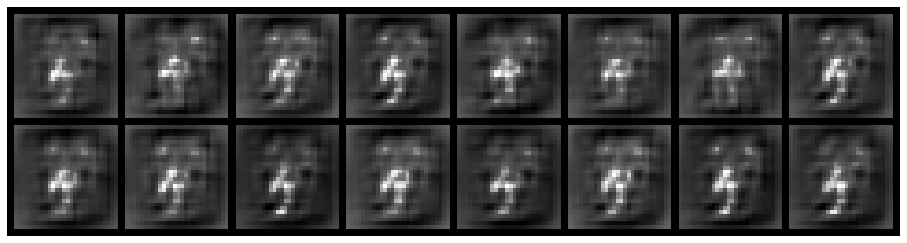

Epoch: [2/100], Batch Num: [0/400]
Discriminator Loss: 1.4029, Generator Loss: 0.6605
D(x): 0.5127, D(G(z)): 0.5159


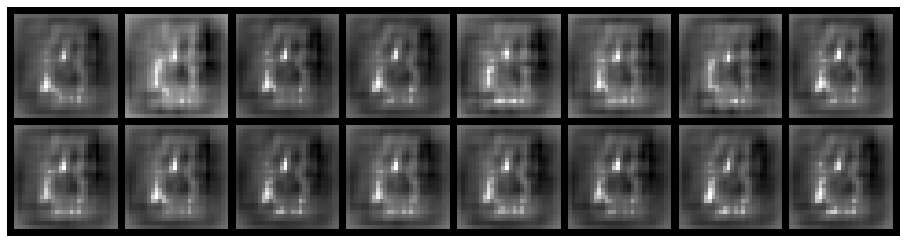

Epoch: [2/100], Batch Num: [100/400]
Discriminator Loss: 1.3781, Generator Loss: 0.7245
D(x): 0.4941, D(G(z)): 0.4875


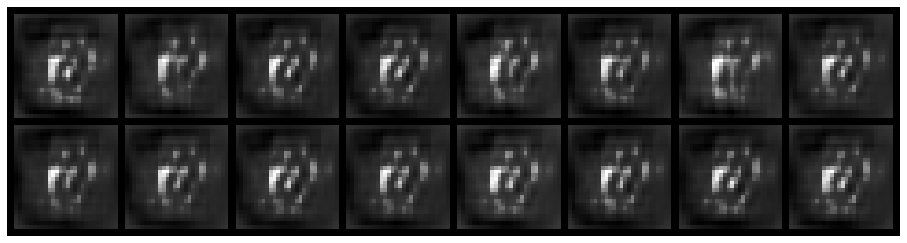

Epoch: [2/100], Batch Num: [200/400]
Discriminator Loss: 1.4827, Generator Loss: 0.6148
D(x): 0.5385, D(G(z)): 0.5714


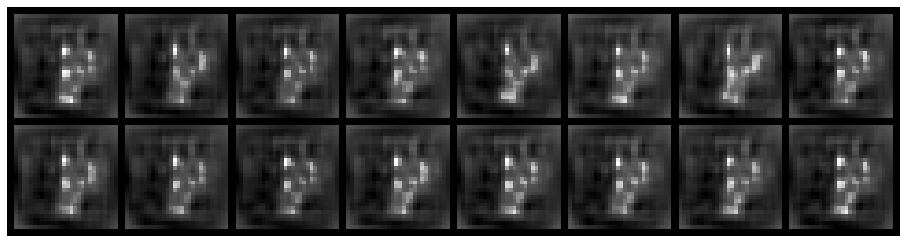

Epoch: [2/100], Batch Num: [300/400]
Discriminator Loss: 1.2768, Generator Loss: 0.7641
D(x): 0.5343, D(G(z)): 0.4729


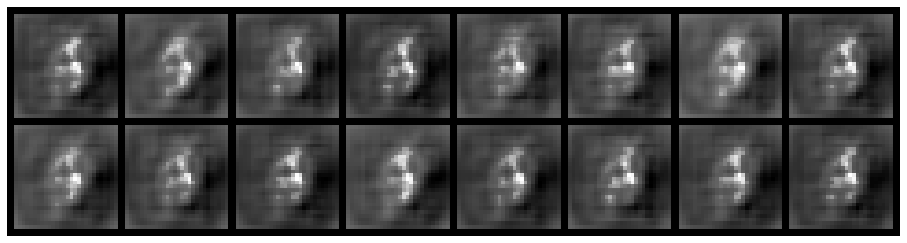

Epoch: [3/100], Batch Num: [0/400]
Discriminator Loss: 1.2942, Generator Loss: 1.0504
D(x): 0.4459, D(G(z)): 0.3663


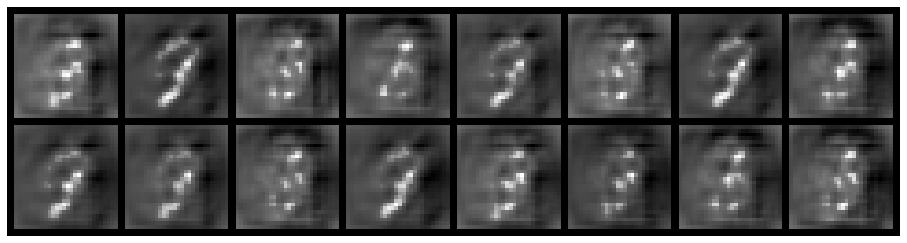

Epoch: [3/100], Batch Num: [100/400]
Discriminator Loss: 1.3454, Generator Loss: 0.7936
D(x): 0.5104, D(G(z)): 0.4681


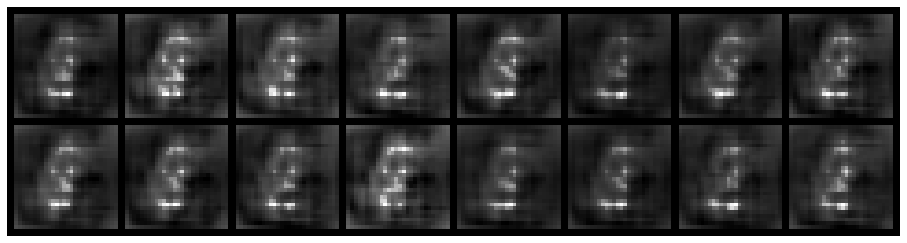

Epoch: [3/100], Batch Num: [200/400]
Discriminator Loss: 1.6314, Generator Loss: 0.7800
D(x): 0.4770, D(G(z)): 0.5263


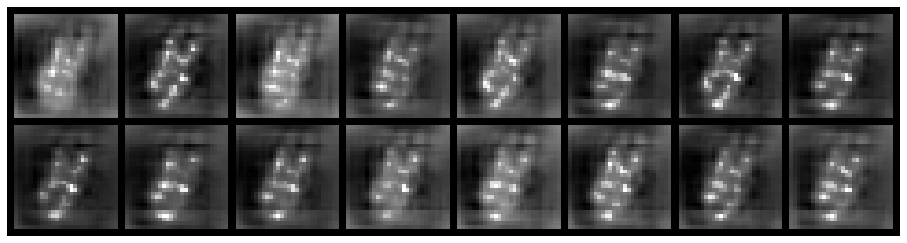

Epoch: [3/100], Batch Num: [300/400]
Discriminator Loss: 1.2995, Generator Loss: 1.0947
D(x): 0.5040, D(G(z)): 0.3722


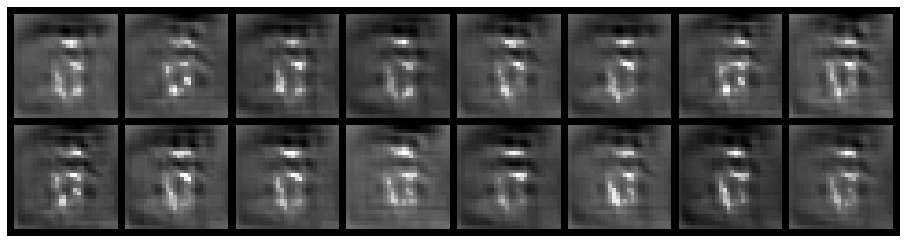

Epoch: [4/100], Batch Num: [0/400]
Discriminator Loss: 1.1619, Generator Loss: 0.9420
D(x): 0.5985, D(G(z)): 0.4251


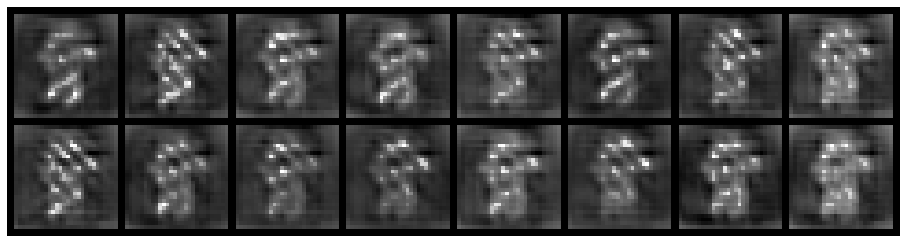

Epoch: [4/100], Batch Num: [100/400]
Discriminator Loss: 0.7649, Generator Loss: 1.3017
D(x): 0.7210, D(G(z)): 0.3066


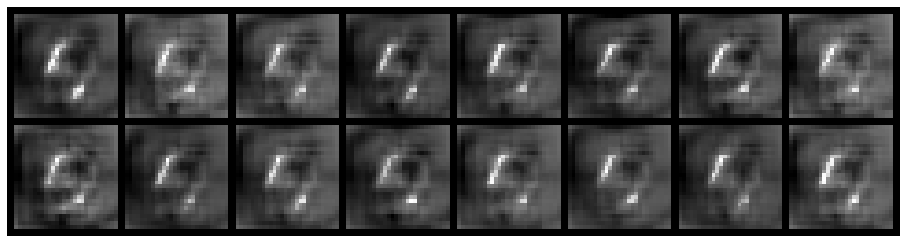

Epoch: [4/100], Batch Num: [200/400]
Discriminator Loss: 0.7709, Generator Loss: 1.2933
D(x): 0.7207, D(G(z)): 0.3011


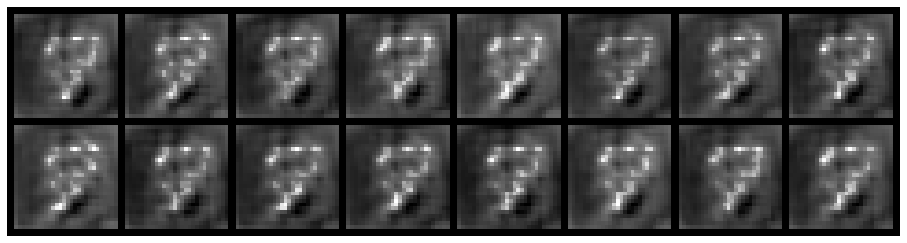

Epoch: [4/100], Batch Num: [300/400]
Discriminator Loss: 0.7003, Generator Loss: 1.6692
D(x): 0.7563, D(G(z)): 0.2545


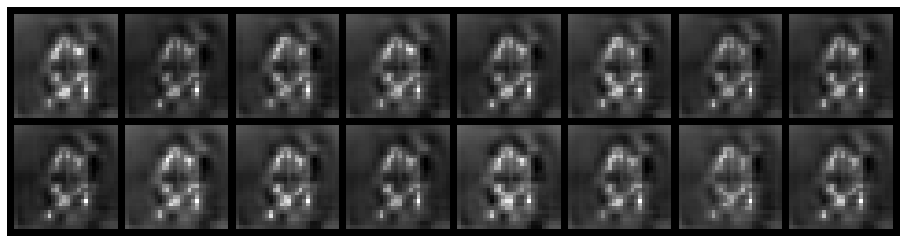

Epoch: [5/100], Batch Num: [0/400]
Discriminator Loss: 1.0735, Generator Loss: 1.5797
D(x): 0.5818, D(G(z)): 0.3065


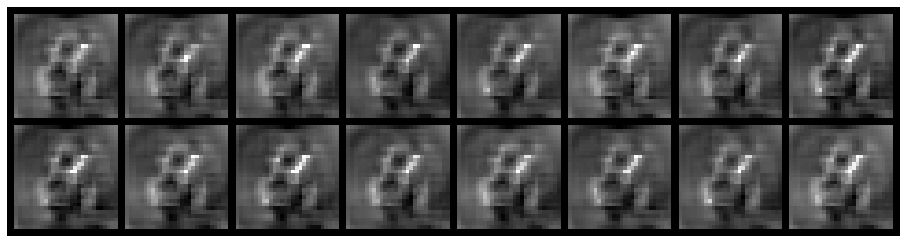

Epoch: [5/100], Batch Num: [100/400]
Discriminator Loss: 0.8717, Generator Loss: 1.2726
D(x): 0.8918, D(G(z)): 0.4688


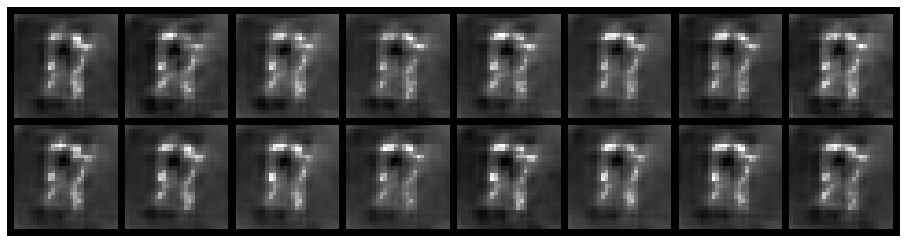

Epoch: [5/100], Batch Num: [200/400]
Discriminator Loss: 0.4884, Generator Loss: 2.2843
D(x): 0.7905, D(G(z)): 0.1476


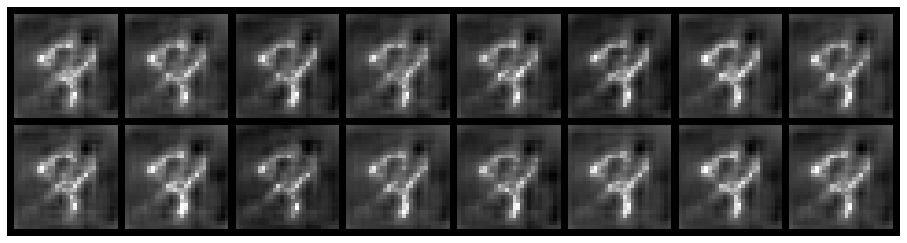

Epoch: [5/100], Batch Num: [300/400]
Discriminator Loss: 0.5624, Generator Loss: 1.9332
D(x): 0.8125, D(G(z)): 0.1984


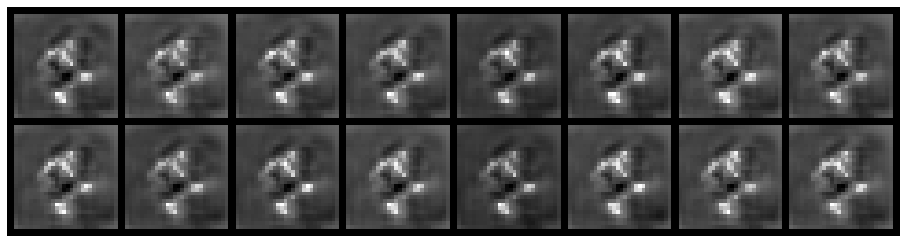

Epoch: [6/100], Batch Num: [0/400]
Discriminator Loss: 0.6495, Generator Loss: 2.3285
D(x): 0.7543, D(G(z)): 0.1833


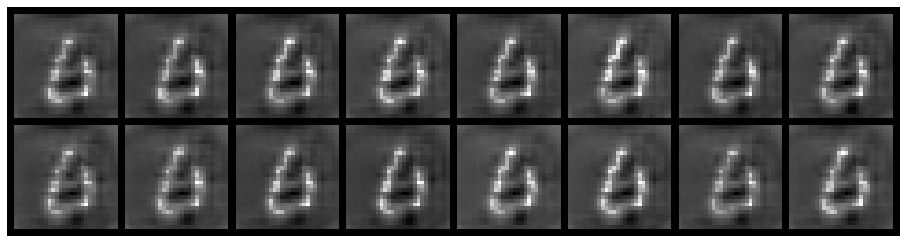

Epoch: [6/100], Batch Num: [100/400]
Discriminator Loss: 0.5574, Generator Loss: 2.5325
D(x): 0.7937, D(G(z)): 0.1746


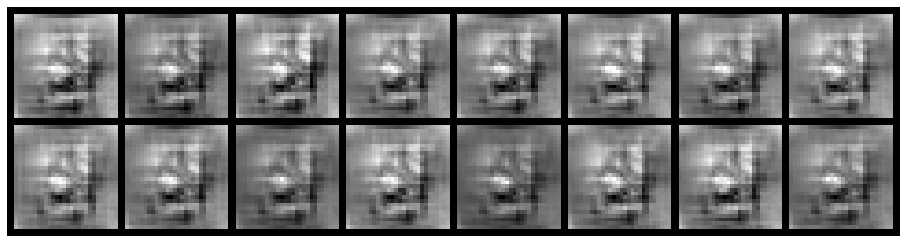

Epoch: [6/100], Batch Num: [200/400]
Discriminator Loss: 0.0798, Generator Loss: 3.4420
D(x): 0.9746, D(G(z)): 0.0448


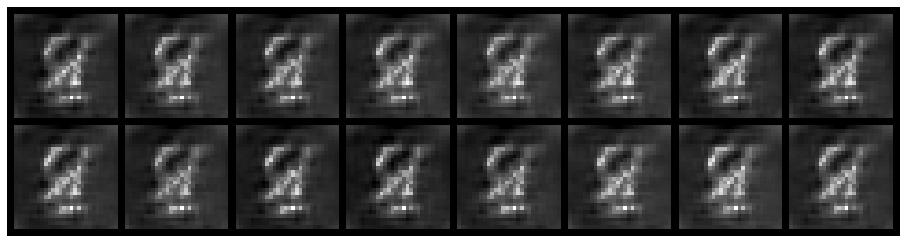

Epoch: [6/100], Batch Num: [300/400]
Discriminator Loss: 0.4473, Generator Loss: 1.9461
D(x): 0.8370, D(G(z)): 0.1676


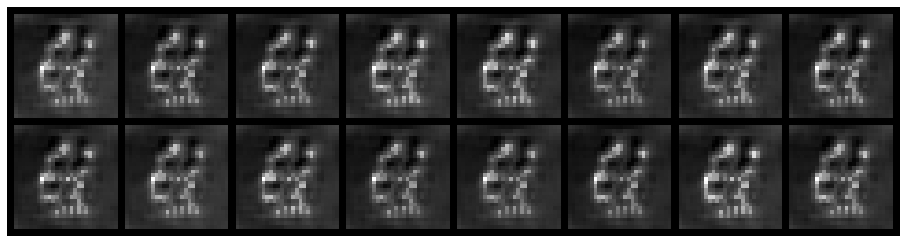

Epoch: [7/100], Batch Num: [0/400]
Discriminator Loss: 0.4661, Generator Loss: 2.0996
D(x): 0.8669, D(G(z)): 0.2117


KeyboardInterrupt: 

In [69]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 100#200

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(image_loader):
        N = real_batch.size(0)
        
        # 1. Train Discriminator
        #real_data = Variable(images_to_vectors(real_batch))
        real_batch = Variable(real_batch)
        # Generate fake data and detach (so gradients are not calculated for generator)
        fake_data = generator(noise(N).to(device)).detach()
        # Train Discriminator
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_batch.to(device), fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N).to(device))
        # Train Generator
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = generator(test_noise)
            test_images = test_images.data.to("cpu")
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

In [125]:
test_images = vectors_to_images(generator(test_noise))

image = test_images.cpu().detach().numpy()
#plt.imshow(image[0][0], cmap='gray', interpolation='none')

In [52]:
#Test here
test_images = generator(test_noise)

#n_batch, (real_batch,_) = next(enumerate(image_loader))

#real_batch.shape

#plt.imshow(test_images[15][0].cpu().detach().numpy(), cmap='gray', interpolation='none')


#generator.linear1[0]
for parameter in generator.linear1[0].parameters():
    print(parameter)


Parameter containing:
tensor([[ 0.0745,  0.0205, -0.0393,  ..., -0.0230,  0.1038, -0.0727],
        [ 0.0339, -0.0971,  0.0743,  ...,  0.0112,  0.0541,  0.0260],
        [-0.0469, -0.0428, -0.0332,  ..., -0.0671,  0.1067,  0.0563],
        ...,
        [ 0.0168, -0.0692,  0.0922,  ..., -0.0231, -0.0367,  0.0133],
        [-0.0737,  0.0787, -0.0831,  ..., -0.0477, -0.1020,  0.0758],
        [ 0.0718,  0.0427,  0.0688,  ...,  0.0940,  0.1049, -0.0627]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 8.0098e-03, -2.7514e-02,  1.0520e-01,  5.0341e-02, -4.3076e-02,
        -7.8695e-02,  8.7715e-02, -4.9243e-02,  3.7476e-03,  1.3268e-02,
        -6.6344e-02, -4.9629e-02,  4.3311e-02, -3.7838e-02,  1.1404e-01,
        -3.3933e-02,  2.3654e-03, -5.3819e-02,  2.2214e-02,  2.6198e-02,
        -6.7602e-02,  6.6467e-02,  9.7221e-02,  3.9102e-02,  7.1937e-02,
         9.6322e-02,  1.4834e-02, -7.3093e-02,  4.7825e-02, -3.8460e-02,
         2.1200e-03,  1.3761e-02,  9.751

## Resources

* https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
* https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

## Notes

* When using convtranspose in generator, but not conv in discriminator, after 50 epochs, genearated images are not close to the results obtained when using only linear layers.
* Generator seems to be always generating the same image even if you pass n noise samples. Parameters in first linear layers are zeroed just after first loops. After some research, this is called "mode colapse".
* To try solving this problem, I deleted one linear layer to the generator, and adjusted learning rate to 0.0005

## ToDo

* Try to use the approach used in resnet networks